Data Augmentation splitting

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import FileLink, display

# 1) Load your CSV
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')

# 2) Stratified splits: 80% train, 10% val, 10% test
label_col = 'Label'
# first split off 10% for test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[label_col],
    random_state=777
)
# then split the 90% into 80/10
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    stratify=train_val_df[label_col],
    random_state=777
)

# 3) Save each split as CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# 4) Display download links in notebook
print("Download your splits:")
display(FileLink('train.csv'))
display(FileLink('val.csv'))
display(FileLink('test.csv'))

Download your splits:


/content/train.csv

/content/val.csv

/content/test.csv

#Part-B [15 points]: Multiclass App Review Classification: from scratch

Dataset analysis and report on important statistics.

,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others


Shape: 2900 rows, 2 columns

Data types:
review    object
Label     object
dtype: object

Missing values per column:
review    0
Label     0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
       review_length
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000

Class distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64
Label
rating                 0.447586
bug_report             0.260690
improvement_request    0.152414
others                 0.139310
Name: proportion, dtype: float64


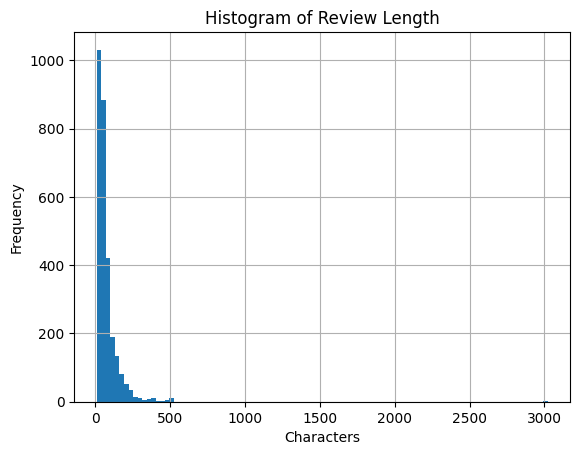

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')
display(df.head())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
print(df['Label'].value_counts())
# view class balance as precentage
print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

# we have a review with 3023 charecters, we could remove it.
# we have data inbalance, we could upscale or downscale, it would be better to upscale

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, MaxPooling1D, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [5]:
# Evaluation & report
def eval_and_report(model, seq, true_y, label_encoder):
    preds = np.argmax(model.predict(seq), axis=1)
    print(classification_report(true_y, preds,
          target_names=label_encoder.classes_))
    cm = confusion_matrix(true_y, preds)
    print("Confusion matrix:\n", cm)

Train the word embeddings from scratch

In [11]:
from sklearn.utils import class_weight
le = LabelEncoder()

df_train = pd.read_csv('train.csv')
# Extract texts and labels
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
# Extract texts and labels
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
# Extract texts and labels
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                          maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),
                          maxlen=MAX_LEN, padding='post')

# Model A: embeddings from scratch
model_scratch = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense( len(le.classes_), activation='softmax')
])
# model_scratch = Sequential([
#     Embedding(
#         input_dim=MAX_VOCAB,
#         output_dim=128,
#         #weights=[embedding_matrix],
#         input_length=MAX_LEN,
#         trainable=True,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(len(le.classes_), activation='softmax', name='output')
# ], name='multilabel_rnn')
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# early stopping
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',
        mode='max',
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
# build to show parameters
model_scratch.build(input_shape=(None, MAX_LEN))
model_scratch.summary()


# class imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

# Train Model A
history_a = model_scratch.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks
)
emb_matrix = model_scratch.layers[0].get_weights()[0]
print("Embedding matrix shape:", emb_matrix.shape)  # -> (vocab_size, embed_dim)

# save Embeddings
np.save('scratch_embeddings.npy', emb_matrix)

# save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("=== Model A (scratch) ===")
eval_and_report(model_scratch, test_seq, y_test, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 600, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,332 (10.14 MB)

 Trainable params: 2,659,332 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.3223 - loss: 1.3831 - val_accuracy: 0.4655 - val_loss: 1.3252
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5407 - loss: 1.2935 - val_accuracy: 0.5747 - val_loss: 1.1821
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7757 - loss: 0.9776 - val_accuracy: 0.6494 - val_loss: 0.9574
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8531 - loss: 0.5617 - val_accuracy: 0.6178 - val_loss: 0.9877
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8804 - loss: 0.3857 - val_accuracy: 0.6466 - val_loss: 0.9220
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9676 - loss: 0.1400 - val_accuracy: 0.6523 - val_loss: 0.9506
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9872 - loss: 0.0691 - val_accuracy: 0.6236 - val_loss: 1.2042
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9921 - loss: 0.0422 - val_accuracy: 0.6351 - v

#with augmentations

In [13]:
le = LabelEncoder()
#y = le.fit_transform(labels)

df_train = pd.read_csv('train_augmented.csv')
print("Augmented data shape: ",df_train.shape)
# 2) Extract texts and labels
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
# 2) Extract texts and labels
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
# 2) Extract texts and labels
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                          maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),
                          maxlen=MAX_LEN, padding='post')

# Model A: embeddings from scratch with augmentation data
model_scratch = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense( len(le.classes_), activation='softmax')
])
# model_scratch = Sequential([
#     Embedding(
#         input_dim=MAX_VOCAB,
#         output_dim=128,
#         #weights=[embedding_matrix],
#         input_length=MAX_LEN,
#         trainable=True,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(len(le.classes_), activation='softmax', name='output')
# ], name='multilabel_rnn')
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',
        mode='max',
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]

model_scratch.build(input_shape=(None, MAX_LEN))
model_scratch.summary()

# Train Model A
history_a = model_scratch.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
emb_matrix = model_scratch.layers[0].get_weights()[0]
print("Embedding matrix shape:", emb_matrix.shape)  # -> (vocab_size, embed_dim)

# save Embeddings
np.save('scratch_embeddings_aug.npy', emb_matrix)

# save tokenizer
with open('tokenizer_aug.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Evaluation & report
def eval_and_report(model, seq, true_y, label_encoder):
    preds = np.argmax(model.predict(seq), axis=1)
    print(classification_report(true_y, preds,
          target_names=label_encoder.classes_))
    cm = confusion_matrix(true_y, preds)
    print("Confusion matrix:\n", cm)

print("=== Model A (scratch) ===")
eval_and_report(model_scratch, test_seq, y_test, le)

Augmented data shape:  (4800, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 600, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,332 (10.14 MB)

 Trainable params: 2,659,332 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5065 - loss: 1.1810 - val_accuracy: 0.5718 - val_loss: 1.0317
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8853 - loss: 0.3294 - val_accuracy: 0.6782 - val_loss: 0.9001
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9559 - loss: 0.1541 - val_accuracy: 0.6753 - val_loss: 0.9594
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9892 - loss: 0.0527 - val_accuracy: 0.6667 - val_loss: 1.0341
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9960 - loss: 0.0230 - val_accuracy: 0.6638 - val_loss: 1.2306
Embedding matrix shape: (20000, 128)
=== Model A (scratch) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
                     precision    recall  f1-score   support

         bug_report       0.62      0.78      0.69       151
improvement_request       0.62      0.34      0.44        88
             others       0.52      0.27      0.36        81
             rati

Use precomputed embeddings (similar to word2vec or Glove for Arabic)

For ensuring Gensim works

In [14]:
# for Gensim to work for AraVec
!pip install --upgrade numpy
!pip install --upgrade gensim
!clear

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 118.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━

In [2]:
# Download AraVec embedding
!wget "https://archive.org/download/aravec2.0/tweet_cbow_300.zip"
!unzip "tweet_cbow_300.zip"

--2025-05-12 17:44:50--  https://archive.org/download/aravec2.0/tweet_cbow_300.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia903107.us.archive.org/0/items/aravec2.0/tweet_cbow_300.zip [following]
--2025-05-12 17:44:51--  https://ia903107.us.archive.org/0/items/aravec2.0/tweet_cbow_300.zip
Resolving ia903107.us.archive.org (ia903107.us.archive.org)... 207.241.232.147
Connecting to ia903107.us.archive.org (ia903107.us.archive.org)|207.241.232.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746111232 (712M) [application/zip]
Saving to: ‘tweet_cbow_300.zip’

tweet_cbow_300.zip  100%[===================>] 711.55M  2.53MB/s    in 3m 42s  

2025-05-12 17:48:34 (3.20 MB/s) - ‘tweet_cbow_300.zip’ saved [746111232/746111232]

Archive:  tweet_cbow_300.zip
  inflating: tweets_cbow_300         
  inflating: tweets_cbo

In [9]:
import numpy as np
import gensim
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

le = LabelEncoder()

df_train = pd.read_csv('train.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Cleaning function For aravec
import re
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",
              '"',"ـ","'","ى","\\",'\n','\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","","ي","",' ',' ',' ',' ? ',' ؟ ',' ! ']
    # remove tashkeel
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', "", text)
    # collapse repeated chars
    text = re.sub(r'(.)\1+', r"\1\1", text)
    # simple normalizations
    text = text.replace('وو','و').replace('يي','ي').replace('اا','ا')
    for s, r in zip(search, replace):
        text = text.replace(s, r)
    return text.strip()

# Apply cleaning before tokenization
X_train = [ clean_str(t) for t in X_train ]
X_val   = [ clean_str(t) for t in X_val ]
X_test  = [ clean_str(t) for t in X_test ]

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=MAX_LEN, padding='post')

# Get Embedding matrix from aravec
EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

vocab_size, embedding_dim = embedding_matrix.shape
#  Define & compile Model B using Aravec
model_pretrained = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_pretrained.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',
        mode='max',
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
model_pretrained.build(input_shape=(None, MAX_LEN))
model_pretrained.summary()

# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(weights))

# Train Model B
history_b = model_pretrained.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    #class_weight=class_weight_dict,
    callbacks=callbacks
)

print("\n=== Model B (pre-trained embeddings) ===")
eval_and_report(model_pretrained, test_seq, y_test, le)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 600, 300)       │    99,503,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,691,096 (380.29 MB)

 Trainable params: 187,396 (732.02 KB)

 Non-trainable params: 99,503,700 (379.58 MB)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4193 - loss: 1.3375 - val_accuracy: 0.5230 - val_loss: 1.1494
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5754 - loss: 1.0525 - val_accuracy: 0.5603 - val_loss: 1.0860
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6267 - loss: 0.9502 - val_accuracy: 0.5546 - val_loss: 1.0528
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6940 - loss: 0.8060 - val_accuracy: 0.5833 - val_loss: 1.0340
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7343 - loss: 0.7297 - val_accuracy: 0.5920 - val_loss: 1.0062
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7905 - loss: 0.6048 - val_accuracy: 0.6006 - val_loss: 1.0333
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8450 - loss: 0.5234 - val_accuracy: 0.6034 - val_loss: 1.0614
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8807 - loss: 0.4216 - val_accuracy: 0.6092 - v

#With augmentation (pretrained embedding)

In [12]:
import numpy as np
import gensim
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

le = LabelEncoder()

df_train = pd.read_csv('train_augmented.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Cleaning Text
import re
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",
              '"',"ـ","'","ى","\\",'\n','\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","","ي","",' ',' ',' ',' ? ',' ؟ ',' ! ']
    # remove tashkeel
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', "", text)
    # collapse repeated chars
    text = re.sub(r'(.)\1+', r"\1\1", text)
    # simple normalizations
    text = text.replace('وو','و').replace('يي','ي').replace('اا','ا')
    for s, r in zip(search, replace):
        text = text.replace(s, r)
    return text.strip()

# Apply cleaning before tokenization
X_train = [ clean_str(t) for t in X_train ]
X_val   = [ clean_str(t) for t in X_val ]
X_test  = [ clean_str(t) for t in X_test ]

# Tokanize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=MAX_LEN, padding='post')

EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

vocab_size, embedding_dim = embedding_matrix.shape
# Define & compile Model B using AraVec
model_pretrained = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_pretrained.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',  # ← switch from val_loss to val_accuracy
        mode='max',              # “higher is better” for accuracy
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]

model_pretrained.build(input_shape=(None, MAX_LEN))
model_pretrained.summary()

# Train Model B
history_b = model_pretrained.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

print("\n=== Model B (pre-trained embeddings) ===")
eval_and_report(model_pretrained, test_seq, y_test, le)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 600, 300)       │    99,503,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,691,096 (380.29 MB)

 Trainable params: 187,396 (732.02 KB)

 Non-trainable params: 99,503,700 (379.58 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6312 - loss: 0.9121 - val_accuracy: 0.5575 - val_loss: 1.1054
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8298 - loss: 0.4426 - val_accuracy: 0.5632 - val_loss: 1.0652
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8713 - loss: 0.3646 - val_accuracy: 0.5891 - val_loss: 1.0478
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9019 - loss: 0.2895 - val_accuracy: 0.6006 - val_loss: 1.0354
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9262 - loss: 0.2326 - val_accuracy: 0.6092 - val_loss: 1.0024
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9477 - loss: 0.1800 - val_accuracy: 0.5920 - val_loss: 1.0303
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9557 - loss: 0.1486 - val_accuracy: 0.6178 - val_loss: 1.0471
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9721 - loss: 0.1104 - val_accuracy: 0.6293 - v

Classification analysis and possible improvements.

We can see that created Embedding preformed sligtly better than AraVec which may be the result of not training AraVec with more data as it is larger than the scratch embedding

For classification, the RNN model performance is not that bad as it scores 0,66 f1-score for best of the four and the role of data augmentation did pay off as it boosted the model performce little bit and made it not leave all models.

We tried more complex model (commented) but it did not improve the overall performance and takes more time to train so we sticked with simpler model


#Part-C [15 points]: Multilabel App Review Classification: from scratch

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import FileLink, display

# Load data
df = pd.read_csv('/content/App Reviews-Multilabel.csv')

# splits: 80% train, 20% test
#label_col = ["bug_report",	"improvement_request",	"rating",	"others"]
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=777
)
# then split into 85/15
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    random_state=777
)

# 3) Save each split as CSV
train_df.to_csv('train_multi.csv', index=False)
val_df.to_csv('val_multi.csv', index=False)
test_df.to_csv('test_multi.csv', index=False)

# 4) Display download links in notebook
print("Download your splits:")
display(FileLink('train_multi.csv'))
display(FileLink('val_multi.csv'))
display(FileLink('test_multi.csv'))

Download your splits:


/content/train_multi.csv

/content/val_multi.csv

/content/test_multi.csv

Dataset analysis and report on important statistics.

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1


Shape: 2900 rows, 5 columns

Data types:
review                 object
bug_report              int64
improvement_request     int64
rating                  int64
others                  int64
dtype: object

Missing values per column:
review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
        bug_report  improvement_request       rating       others  \
count  2900.000000          2900.000000  2900.000000  2900.000000   
mean      0.401379             0.380345     0.679655     0.282759   
std       0.490262             0.485555     0.466690     0.450418   
min       0.000000             0.000000     0.000000     0.000000   
25%       0.000000             0.000000     0.000000    

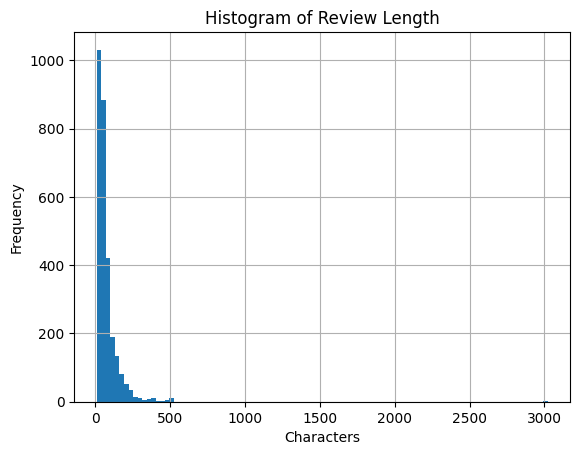

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-Multilabel.csv')
display(df.head())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
bug_report_counts = df['bug_report'].sum()
improvement_request_counts = df['improvement_request'].sum()
rating_counts = df['rating'].sum()
others_counts = df['others'].sum()
print(bug_report_counts,"bug_report")
print(improvement_request_counts,"improvement_request")
print(rating_counts,"rating")
print(others_counts,"others")

# viewing class balance as precentage
total_sum = bug_report_counts + improvement_request_counts + rating_counts + others_counts
print("As precentages")
print((bug_report_counts/total_sum)*100,"%","bug_report")
print((improvement_request_counts/total_sum)*100,"%","improvement_request")
print((rating_counts/total_sum)*100,"%","rating")
print((others_counts/total_sum)*100,"%","others")
#print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

In [22]:
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
    hamming_loss,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

def eval_and_report_multilabel(model, seq, true_y, label_names, threshold=0.5):
    # 1) Predict probabilities and binarize
    preds_proba = model.predict(seq)
    preds = (preds_proba >= threshold).astype(int)

    # 2) Per‐label confusion matrices
    cms = multilabel_confusion_matrix(true_y, preds)
    print("=== Per-label Confusion Matrices ===")
    for idx, label in enumerate(label_names):
        tn, fp, fn, tp = cms[idx].ravel()
        print(f"{label}:  TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # 3) Overall multilabel metrics
    print("\n=== Overall Multilabel Metrics ===")
    print(f"Hamming Loss:    {hamming_loss(true_y, preds):.4f}")
    print(f"Subset Accuracy: {accuracy_score(true_y, preds):.4f}\n")

    # Full per-label classification report
    print("\n=== Classification Report ===")
    print(classification_report(
        true_y,
        preds,
        target_names=label_names,
        zero_division=0
    ))

You can use the best embedding from Part-B

We will use AraVec ( no noticeble difference )

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import pickle

label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]
df_train = pd.read_csv('train_multi.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = df_train[label_cols].values.astype(int)

df_val = pd.read_csv('val_multi.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = df_val[label_cols].values.astype(int)

df_test = pd.read_csv('test_multi.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = df_test[label_cols].values.astype(int)

# TEXT PREPROCESSING
MAX_VOCAB = 20000
MAX_LEN    = 600

# Convert texts to padded sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 4) EMBEDDING MATRIX LOADING
# Assumes you exported embedding_matrix.npy from Part B
EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

# 5) BUILD RNN-BASED MULTILABEL MODEL
vocab_size, embedding_dim = embedding_matrix.shape
num_labels = y_train.shape[1]
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_labels, activation='sigmoid', name='output')
])
# model = Sequential([
#     Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         input_length=MAX_SEQ_LEN,
#         trainable=False,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(num_labels, activation='sigmoid', name='output')
# ], name='multilabel_rnn')
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_LEN))
model.summary()

# 6) TRAIN
EPOCHS = 20
BATCH_SIZE = 32
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',
        mode='max',
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
history = model.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)
eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 600, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,332 (10.14 MB)

 Trainable params: 2,659,332 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3508 - loss: 0.6484 - val_accuracy: 0.3103 - val_loss: 0.6222
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3998 - loss: 0.5802 - val_accuracy: 0.5172 - val_loss: 0.5344
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5552 - loss: 0.5178 - val_accuracy: 0.5201 - val_loss: 0.5777
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5338 - loss: 0.4976 - val_accuracy: 0.5230 - val_loss: 0.5297
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6333 - loss: 0.4129 - val_accuracy: 0.5316 - val_loss: 0.5204
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6546 - loss: 0.3402 - val_accuracy: 0.5230 - val_loss: 0.5300
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6737 - loss: 0.2731 - val_accuracy: 0.5345 - val_loss: 0.5487
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6911 - loss: 0.2091 - val_accuracy: 0.5345 - v

In [28]:
# build a set of all train reviews
train_texts = set(df_train['review'])
overlap = train_texts.intersection(df_test['review'])
print("Overlap between train & test:", len(overlap))

Overlap between train & test: 1


#With augmentation

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import pickle

label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]
df_train = pd.read_csv('eda_full_augmented_train_multi.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = df_train[label_cols].values.astype(int)

df_val = pd.read_csv('val_multi.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = df_val[label_cols].values.astype(int)

df_test = pd.read_csv('test_multi.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = df_test[label_cols].values.astype(int)

# TEXT PREPROCESSING
MAX_VOCAB = 20000
MAX_LEN    = 600

# Convert texts to padded sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 4) EMBEDDING MATRIX LOADING
# Assumes you exported embedding_matrix.npy from Part B
EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

# 5) BUILD RNN-BASED MULTILABEL MODEL
vocab_size, embedding_dim = embedding_matrix.shape
num_labels = y_train.shape[1]
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_labels, activation='sigmoid', name='output')
])
# model = Sequential([
#     Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         input_length=MAX_SEQ_LEN,
#         trainable=False,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(num_labels, activation='sigmoid', name='output')
# ], name='multilabel_rnn')
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_LEN))
model.summary()

# 6) TRAIN
EPOCHS = 20
BATCH_SIZE = 32
callbacks = [
    EarlyStopping(
        #monitor="val_loss",
        monitor='val_accuracy',
        mode='max',
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
history = model.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)
eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 600, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,332 (10.14 MB)

 Trainable params: 2,659,332 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2743 - loss: 0.6675 - val_accuracy: 0.5086 - val_loss: 0.5690
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5376 - loss: 0.4730 - val_accuracy: 0.5632 - val_loss: 0.4987
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6188 - loss: 0.2516 - val_accuracy: 0.5632 - val_loss: 0.5826
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6340 - loss: 0.1403 - val_accuracy: 0.5460 - val_loss: 0.6851
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6349 - loss: 0.0807 - val_accuracy: 0.5489 - val_loss: 0.7708
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
=== Per-label Confusion Matrices ===
bug_report:  TN=281, FP=60, FN=55, TP=184
improvement_request:  TN=286, FP=56, FN=94, TP=144
rating:  TN=97, FP=99, FN=54, TP=330
others:  TN=373, FP=48, FN=91, TP=68

=== Overall Multilabel Metrics ===
Hamming Loss:    0.2401
Subset Accuracy: 0.3759


=== Classification Report

In [71]:
# build a set of all train reviews
train_texts = set(df_train['review'])
overlap = train_texts.intersection(df_test['review'])
print("Overlap between train & test:", len(overlap))

Overlap between train & test: 1


Classification analysis and possible improvements.

The multilabel models did great compared to multiclass as its f1-score are both above 0.70 compred to lower than 0.70. data augmentation did not improve the mirco f1, which may imply that data augmentation techneque did not benfit the model.

possible improvements could be better augmentation as class weight did worse and we may use bigger data set that is balanced

#Part-D [15 points]: Multiclass App Review Classification: Finetune an MLM


Fine-tune a Bert-type model like Arabert or Marbert

In [31]:
# install the AraBERT preprocessor
!pip install arabert

# install Farasa (required by the preprocessor for v1 & v2 tokenization)
!pip install farasapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=8839a75b9b25f2eb0b136f5285bfbec96a9ea105067af4a9a7a520c51faa86d9
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [32]:
from arabert.preprocess import ArabertPreprocessor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from transformers import TrainingArguments

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/656k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1008 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


(array([  0.,  28., 132., 195., 274., 307., 264., 217., 189., 166., 146.,
        129., 102.,  86.,  57.,  69.,  41.,  40.,  47.,  26.,  36.,  33.,
         26.,  22.,  33.,  26.,  12.,  20.,  18.,  10.,   9.,   8.,  12.,
          9.,  10.,  11.,   5.,   3.,   7.,   7.,   3.,   1.,   4.,   0.,
          1.,   0.,   3.,   2.,   4.,   2.,   2.,   3.,   1.,   2.,   2.,
          0.,   4.,   5.,   1.,   1.,   1.,   3.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   0.,   5.,   2.,   1.,   2.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

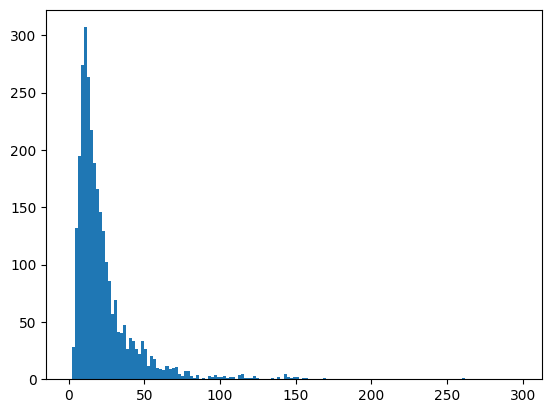

In [33]:
tok = AutoTokenizer.from_pretrained('aubmindlab/bert-large-arabertv2')
print("Training Sentence Lengths: ")
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')
plt.hist([ len(tok.tokenize(sentence)) for sentence in df['review'].to_list()],bins=range(0,300,2))

In [34]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > 200 for sentence in df['review'].to_list()]))

Truncated training sequences:  4


In [54]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

In [55]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        **{f'{lab}_f1': score
           for lab, score in
           zip(label_names,
               __import__('sklearn.metrics').metrics.f1_score(
                   labels, preds, average=None
               ))
        }
    }

In [59]:
le = LabelEncoder()
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

df_train['Label'] = le.fit_transform(df_train['Label'])
# now transform val & test
df_val  ['Label'] = le.transform(df_val['Label'])
df_test ['Label'] = le.transform(df_test['Label'])
label_names = le.classes_
# Dataset class to feed into AraBert
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# AraBERT preprocessing
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-large-arabertv2')
for df_ in (df_train, df_val, df_test):
    df_['review'] = df_['review'].apply(prep.preprocess)

# create dataset and get tokenizer ( pretrained )
MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(
    df_train['review'].tolist(),
    df_train['Label'].tolist(),
    tokenizer
)
val_ds = ReviewDataset(
    df_val['review'].tolist(),
    df_val['Label'].tolist(),
    tokenizer
)
test_ds = ReviewDataset(
    df_test['review'].tolist(),
    df_test['Label'].tolist(),
    tokenizer
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# build the MLM
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# training arguments
training_args = TrainingArguments(
    output_dir='./bert_reviews',
    overwrite_output_dir=True,

    # enable training & evaluation
    do_train=True,
    do_eval=True,

    # run eval and saving at the end of each epoch
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,        # keep only the best/last checkpoint

    # core hyperparameters
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,

    # log every 100 steps
    logging_strategy='steps',
    logging_steps=100,

    # pick up the best model automatically
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)
# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,        # ← pad to max length in each batch
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 9) RUN TRAINING
trainer.train()

# 10) EVALUATION
metrics = trainer.evaluate()
print(metrics)

[2025-05-12 19:32:08,125 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-59-b3550855a6ff>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Bug Report F1,Improvement Request F1,Others F1,Rating F1
1,1.176000,0.964054,0.620690,0.707965,0.000000,0.040816,0.733696
2,0.901600,0.711625,0.758621,0.798030,0.595238,0.563380,0.816568
3,0.655200,0.669422,0.744253,0.748768,0.652632,0.593407,0.814332
4,0.539500,0.658771,0.761494,0.779661,0.716981,0.588235,0.823151
5,0.328500,0.700922,0.790230,0.788889,0.763636,0.632653,0.850649
6,0.256300,0.731623,0.784483,0.791444,0.720000,0.652174,0.839117
7,0.248300,0.766653,0.784483,0.779661,0.756757,0.638298,0.840764
8,0.183200,0.796866,0.784483,0.784530,0.763636,0.645833,0.834951


{'eval_loss': 0.7009221911430359, 'eval_accuracy': 0.7902298850574713, 'eval_bug_report_f1': 0.7888888888888889, 'eval_improvement_request_f1': 0.7636363636363637, 'eval_others_f1': 0.6326530612244898, 'eval_rating_f1': 0.8506493506493507, 'eval_runtime': 1.3635, 'eval_samples_per_second': 255.223, 'eval_steps_per_second': 8.067, 'epoch': 8.0}


In [60]:
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print(classification_report(df_test['Label'], preds, target_names=[str(l) for l in label_names]))

                     precision    recall  f1-score   support

         bug_report       0.83      0.75      0.79       151
improvement_request       0.60      0.73      0.66        88
             others       0.66      0.65      0.66        81
             rating       0.81      0.80      0.80       260

           accuracy                           0.76       580
          macro avg       0.73      0.73      0.73       580
       weighted avg       0.76      0.76      0.76       580



#With Augmentation

In [61]:
le = LabelEncoder()
df_train = pd.read_csv('train_augmented.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

df_train['Label'] = le.fit_transform(df_train['Label'])
# now transform val & test
df_val  ['Label'] = le.transform(df_val['Label'])
df_test ['Label'] = le.transform(df_test['Label'])
label_names = le.classes_
# Dataset class to feed into AraBert
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# AraBERT preprocessing
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-large-arabertv2')
for df_ in (df_train, df_val, df_test):
    df_['review'] = df_['review'].apply(prep.preprocess)

# create dataset and get tokenizer ( pretrained )
MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(
    df_train['review'].tolist(),
    df_train['Label'].tolist(),
    tokenizer
)
val_ds = ReviewDataset(
    df_val['review'].tolist(),
    df_val['Label'].tolist(),
    tokenizer
)
test_ds = ReviewDataset(
    df_test['review'].tolist(),
    df_test['Label'].tolist(),
    tokenizer
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# build the MLM
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# training arguments
training_args = TrainingArguments(
    output_dir='./bert_reviews',
    overwrite_output_dir=True,

    # enable training & evaluation
    do_train=True,
    do_eval=True,

    # run eval and saving at the end of each epoch
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,        # keep only the best/last checkpoint

    # core hyperparameters
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,

    # log every 100 steps
    logging_strategy='steps',
    logging_steps=100,

    # pick up the best model automatically
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)
# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,        # padding to max length in each batch
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 9) RUN TRAINING
trainer.train()

# 10) EVALUATION
metrics = trainer.evaluate()
print(metrics)

[2025-05-12 19:38:33,028 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-61-68117a8ca626>:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Bug Report F1,Improvement Request F1,Others F1,Rating F1
1,0.407600,0.894795,0.681034,0.775510,0.307692,0.411765,0.762712
2,0.248900,0.778468,0.752874,0.769231,0.666667,0.626506,0.815068
3,0.217600,0.731596,0.798851,0.797688,0.779661,0.666667,0.847896
4,0.144900,0.784157,0.790230,0.777778,0.727273,0.651163,0.856250
5,0.096000,0.957699,0.781609,0.784530,0.728972,0.672897,0.837209
6,0.074400,1.001565,0.784483,0.780749,0.725490,0.637363,0.848101


{'eval_loss': 0.7315958738327026, 'eval_accuracy': 0.7988505747126436, 'eval_bug_report_f1': 0.7976878612716763, 'eval_improvement_request_f1': 0.7796610169491526, 'eval_others_f1': 0.6666666666666666, 'eval_rating_f1': 0.8478964401294499, 'eval_runtime': 1.3884, 'eval_samples_per_second': 250.655, 'eval_steps_per_second': 7.923, 'epoch': 6.0}


In [62]:
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print(classification_report(df_test['Label'], preds, target_names=[str(l) for l in label_names]))

                     precision    recall  f1-score   support

         bug_report       0.81      0.72      0.76       151
improvement_request       0.57      0.73      0.64        88
             others       0.62      0.69      0.65        81
             rating       0.83      0.78      0.81       260

           accuracy                           0.74       580
          macro avg       0.71      0.73      0.71       580
       weighted avg       0.76      0.74      0.75       580



Classification analysis and possible improvements.

MLM performance is better than RNN scratch by a big gap which tells is how its pretrained weights can help us in making it domain specific.

more epochs to train more with a bigger dataset

#Part-E [15 points]: Multilabel App Review Classification: Finetune an MLM

Fine-tune a Bert-type model like Arabert or Marbert

In [63]:
df_train = pd.read_csv('train_multi.csv')
df_val = pd.read_csv('val_multi.csv')
df_test = pd.read_csv('test_multi.csv')


TEXT_COL = "review"
LABEL_COLS = ['bug_report','improvement_request','rating','others']
num_labels = len(LABEL_COLS)

# ensure label columns are ints 0/1
df_train[LABEL_COLS] = df_train[LABEL_COLS].astype(int)
df_val[LABEL_COLS]   = df_val[LABEL_COLS].astype(int)
df_test[LABEL_COLS]  = df_test[LABEL_COLS].astype(int)


# AraBERT preprocessing
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-large-arabertv2')
for df_ in (df_train, df_val, df_test):
    df_['review'] = df_['review'].apply(prep.preprocess)

MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=False,
            return_tensors="pt"
        )
        # convert label row to float
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        # HuggingFace Trainer will pick up encoding["labels"]
        encoding["labels"] = label_tensor
        # remove the extra batch dim
        return {k: v.squeeze(0) for k, v in encoding.items()}

train_ds = ReviewDataset(df_train[TEXT_COL].tolist(),
                         df_train[LABEL_COLS].values,
                         tokenizer)
val_ds   = ReviewDataset(df_val[TEXT_COL].tolist(),
                         df_val[LABEL_COLS].values,
                         tokenizer)
test_ds  = ReviewDataset(test_df[TEXT_COL].tolist(),
                         df_test[LABEL_COLS].values,
                         tokenizer)

data_collator = DataCollatorWithPadding(tokenizer)

# model (multilabel)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # triggers BCEWithLogitsLoss
)

training_args = TrainingArguments(
    output_dir="./bert_multilabel",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
)

# metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    subset_acc = accuracy_score(labels, preds)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "subset_accuracy": subset_acc
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# train and evaluate
trainer.train()
print(trainer.evaluate())

[2025-05-12 19:45:20,963 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-63-c813f3b5ce40>:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Subset Accuracy
1,0.646400,0.595324,0.528942,0.288400,0.247126
2,0.576200,0.478233,0.718831,0.619109,0.385057
3,0.483100,0.426118,0.771930,0.708885,0.456897
4,0.424100,0.392089,0.798956,0.750658,0.528736
5,0.334200,0.394859,0.795455,0.745633,0.511494
6,0.314500,0.385544,0.793431,0.742146,0.494253
7,0.303500,0.381774,0.802065,0.764621,0.520115
8,0.284300,0.380439,0.812606,0.775293,0.548851
9,0.254500,0.379431,0.803122,0.761885,0.531609
10,0.249800,0.379706,0.802768,0.760336,0.525862


{'eval_loss': 0.38043883442878723, 'eval_micro_f1': 0.8126064735945485, 'eval_macro_f1': 0.7752926158862644, 'eval_subset_accuracy': 0.5488505747126436, 'eval_runtime': 1.5855, 'eval_samples_per_second': 219.491, 'eval_steps_per_second': 6.938, 'epoch': 10.0}


In [64]:
preds_output = trainer.predict(test_ds)
logits = preds_output.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()

preds = (probs >= 0.5).astype(int)
true = df_test[LABEL_COLS].values.astype(int)
print(classification_report(
    true,
    preds,
    target_names=LABEL_COLS,
    zero_division=0  # avoids warnings if any class has no positives
))

                     precision    recall  f1-score   support

         bug_report       0.81      0.77      0.79       239
improvement_request       0.76      0.72      0.74       238
             rating       0.90      0.84      0.87       384
             others       0.67      0.65      0.66       159

          micro avg       0.81      0.77      0.79      1020
          macro avg       0.79      0.75      0.77      1020
       weighted avg       0.81      0.77      0.79      1020
        samples avg       0.85      0.82      0.80      1020



#With Augmentation

In [67]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

df_train = pd.read_csv('eda_full_augmented_train_multi.csv')
df_val = pd.read_csv('val_multi.csv')
df_test = pd.read_csv('test_multi.csv')


TEXT_COL = "review"
LABEL_COLS = ['bug_report','improvement_request','rating','others']
num_labels = len(LABEL_COLS)

# ensure label columns are ints 0/1
df_train[LABEL_COLS] = df_train[LABEL_COLS].astype(int)
df_val[LABEL_COLS]   = df_val[LABEL_COLS].astype(int)
df_test[LABEL_COLS]  = df_test[LABEL_COLS].astype(int)


# AraBERT preprocessing
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-large-arabertv2')
for df_ in (df_train, df_val, df_test):
    df_['review'] = df_['review'].apply(prep.preprocess)

MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=False,
            return_tensors="pt"
        )
        # convert label row to float
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        # HuggingFace Trainer will pick up encoding["labels"]
        encoding["labels"] = label_tensor
        # remove the extra batch dim
        return {k: v.squeeze(0) for k, v in encoding.items()}

train_ds = ReviewDataset(df_train[TEXT_COL].tolist(),
                         df_train[LABEL_COLS].values,
                         tokenizer)
val_ds   = ReviewDataset(df_val[TEXT_COL].tolist(),
                         df_val[LABEL_COLS].values,
                         tokenizer)
test_ds  = ReviewDataset(test_df[TEXT_COL].tolist(),
                         df_test[LABEL_COLS].values,
                         tokenizer)

data_collator = DataCollatorWithPadding(tokenizer)

# model (multilabel)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # triggers BCEWithLogitsLoss
)

training_args = TrainingArguments(
    output_dir="./bert_multilabel",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    num_train_epochs=10,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
)

# metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    subset_acc = accuracy_score(labels, preds)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "subset_accuracy": subset_acc
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# train and evaluate
trainer.train()
print(trainer.evaluate())

[2025-05-12 20:04:39,981 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-67-5ec64b8e449f>:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Subset Accuracy
1,0.658800,0.619923,0.600897,0.441042,0.252874
2,0.581300,0.470442,0.751084,0.685317,0.433908
3,0.438700,0.401987,0.796327,0.759447,0.488506
4,0.366900,0.377513,0.792164,0.752110,0.500000
5,0.290300,0.382280,0.801674,0.772851,0.488506
6,0.246100,0.399673,0.795608,0.761638,0.485632
7,0.215800,0.410071,0.791561,0.751378,0.488506
8,0.196400,0.416586,0.797649,0.760712,0.494253
9,0.164300,0.420388,0.800333,0.766667,0.494253
10,0.156100,0.427995,0.804312,0.769655,0.500000


{'eval_loss': 0.4279947876930237, 'eval_micro_f1': 0.8043117744610282, 'eval_macro_f1': 0.7696554642244635, 'eval_subset_accuracy': 0.5, 'eval_runtime': 1.5838, 'eval_samples_per_second': 219.727, 'eval_steps_per_second': 6.945, 'epoch': 10.0}


In [68]:
preds_output = trainer.predict(test_ds)
logits = preds_output.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()

preds = (probs >= 0.5).astype(int)
true = df_test[LABEL_COLS].values.astype(int)
print(classification_report(
    true,
    preds,
    target_names=LABEL_COLS,
    zero_division=0  # avoids warnings if any class has no positives
))

                     precision    recall  f1-score   support

         bug_report       0.77      0.83      0.80       239
improvement_request       0.72      0.79      0.76       238
             rating       0.88      0.87      0.87       384
             others       0.63      0.65      0.64       159

          micro avg       0.78      0.81      0.79      1020
          macro avg       0.75      0.79      0.77      1020
       weighted avg       0.78      0.81      0.79      1020
        samples avg       0.83      0.85      0.80      1020



In [69]:
train_texts = set(df_train['review'])
overlap = train_texts.intersection(df_test['review'])
print("Overlap between train & test:", len(overlap))

Overlap between train & test: 2


Classification analysis and possible improvements.

MLM did a great job exceeding 0.75 f1 score and improving by 0,08 compared to RNN as previously said.

augmentation did not improve the performance that much